In [87]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


## 0. Small Demo of bagging a dataset
We show how dataset bagging works firstly in detail

In [88]:
def get_bagging_datasets(ori_dataset, num_bagging, size_bagging, replace):
    """
    Given the original dataset, generate multiple bagging datasets with 
    desired size
    
    Args:
        ori_dataset: original dataset, shape [num_data_pts, dim_data]
        
        num_bagging: number of bagging datasets to be generated
        
        size_bagging: size of each bagging dataset
        
        replace: if repeated data shall exist in one bagging set
        
    Returns:        
        bagging_datasets, shape [num_bagging, size_bagging, dim_data] 
        
        bagging_indices, show how the bagging is operated
    """
        
    # Get the length of the original dataset
    num_data = len(ori_dataset)
    
    # Get the size of the desired bagging indices matrix
    bagging_indices_shape = (num_bagging,
                             size_bagging)
    
    bagging_indices = np.zeros(bagging_indices_shape, dtype=int)
    
    # Now generate random indices
    for i in range(num_bagging):
        bagging_indices[i] = np.random.choice(num_data,
                                              size_bagging,
                                              replace=replace)    
    
    # Use indices to get bagging datasets
    bagging_datasets = ori_dataset[bagging_indices]    
    
    # Return
    return bagging_datasets, bagging_indices

### Use the 10 pts dataset as an example

In [89]:
training_data = np.load('training_data.npy')
baggings, bagging_indices = get_bagging_datasets(training_data, 5, 5, replace=False)
# Print the indices of the bagging, sorted 
print(np.sort(bagging_indices, axis=1)) 

[[0 2 4 7 8]
 [0 1 3 6 8]
 [2 3 4 5 9]
 [0 1 6 7 9]
 [0 1 6 8 9]]


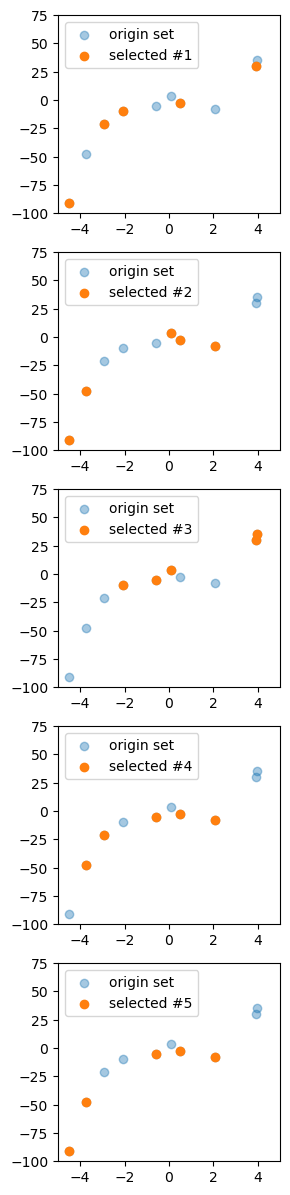

In [90]:
%matplotlib inline  
plt.figure(figsize=(3,12), dpi=100, tight_layout=True)

for i in range(5):
    plt.subplot(5,1,i+1)
    plt.xlim([-5,5])
    plt.ylim([-100,75])
    plt.scatter(training_data[:,0], training_data[:,1], label='origin set', alpha=0.4)
    plt.scatter(baggings[i,:,0], baggings[i,:,1], label=f'selected #{i+1}')
    plt.legend()
plt.show()


# Bagging with Trees in MNIST dataset using scikit
Modified from: https://github.com/shreyans29/thesemicolon

Here we:
- Classify handwritting digits (0-9) using MNIST dataset
- Use bagging wrappers from scikit
- Train multiple models with different number of trees 
- Each tree has a bagging set (subset of the original training dataset)

## 1. Load data and plot a digit as example

In [91]:
df_x = pd.read_csv('mnist_mini_x.csv')
df_y = pd.read_csv('mnist_mini_y.csv')

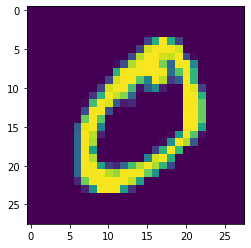

In [92]:
%matplotlib inline

demo_array = np.asarray(df_x.loc[0,:])
plt.figure()
plt.imshow(demo_array.reshape([28, 28]))
plt.show()


## 2. Fit all data in ONE decision tree as a comparison

In [93]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, 
                                                    test_size=0.2, 
                                                    random_state=4)

In [94]:
#descision tree
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)

DecisionTreeClassifier()

### Training accuracy - 1 tree

In [95]:
dt.score(x_train,y_train) # Get 100% accuracy

1.0

### Test accuracy - 1 tree, overfitting

In [96]:
tree1_test_accuracy = dt.score(x_test,y_test) 
print(tree1_test_accuracy) # Get 80% accuracy, so overfitting

0.8045


## 3. Train multiple trees using Bagging
Need apprx. 30 seconds to train

In [97]:
training_accuracy = []
testing_accuracy = []
max_num_trees = 10

#Bagging 
#
# Model 1 contains 1 tree
# Model 2 contains 2 trees
#          ...
# Mode 10 contains 10 trees
#
# Each tree is trained by a subset of the original training dataset 

for num_estimator in range(1, max_num_trees + 1):
    bg = BaggingClassifier(DecisionTreeClassifier(), 
                           max_samples= 0.5, max_features = 1.0, 
                           n_estimators = num_estimator)
    bg.fit(x_train,y_train.values.ravel())
    training_accuracy.append(bg.score(x_train,y_train))
    testing_accuracy.append(bg.score(x_test,y_test))

    

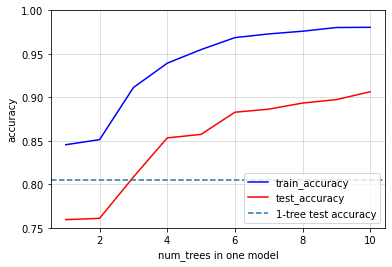

In [98]:
%matplotlib inline
plt.figure()
plt.plot(range(1, max_num_trees + 1),
         training_accuracy, 
         label="train_accuracy", color='b')
plt.plot(range(1, max_num_trees + 1),
         testing_accuracy, 
         label="test_accuracy", color='r')

plt.xlabel("num_trees in one model")
plt.ylabel("accuracy")
plt.ylim([0.75,1.0])
plt.grid(alpha=0.5)
plt.axhline(tree1_test_accuracy, 
            linestyle='--',
            label="1-tree test accuracy")

plt.legend()
plt.show()


### Summary
- For each tree in the model, it cannot reach 100% training accuracy anymore due to bagging data selection. 
- When the number of trees in one model increases, both training and testing accuracy increase.
- Get + 10% testing accuracy, compared with the one tree model without using a bigger dataset.